# DATA MINING PROJECT - PROTEIN BLOCKS

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import sets
from IPython.display import Image

In [2]:
df = pd.read_csv("March_2024_PDB_01.txt", sep=r"\s+", header=None)
df.columns = ['Protein_number', 'PB1', 'PB2', 'expected_frequency', 'AA1', 'AA2', 'S2_1', 'S2_2']
df

,Protein_number,PB1,PB2,expected_frequency,AA1,AA2,S2_1,S2_2
0,1,p,f,0.941295,H,E,C,S
1,1,f,c,0.322290,W,P,S,S
2,1,o,l,0.412006,T,Q,C,C
3,3,b,i,0.298008,V,G,C,C
4,4,j,c,0.151741,G,R,E,E
...,...,...,...,...,...,...,...,...
5370,1720,n,p,0.202308,C,L,S,C
5371,1720,g,m,0.088315,S,E,T,T
5372,1720,h,o,0.194438,K,K,S,S
5373,1720,b,i,0.298008,P,N,C,C


## Unexpected transitions between protein blocks

In [3]:
def filter_data_set(data, rm_columns : list, req_col_str : str):
    data = data.drop(rm_columns, axis=1)
    data[req_col_str] = ""
    for req_col in req_col_str.split('-'):
        data[req_col_str] += data[req_col].str.upper()
    value_counts = data[req_col_str].value_counts()
    data[req_col_str + '-count'] = data[req_col_str].map(value_counts)
    if req_col_str != 'PB1-PB2':
        data[req_col_str] = data[req_col_str].apply(lambda x: ''.join(sorted(x))) # when determinig aa / s2 / aa & s2 and pairs such as (A,C) & (C,A) are found, they are essentially the same pair therefore shouldn't be considered separately
        
    data = data.drop_duplicates(subset=[req_col_str]).sort_values(by=str(req_col_str + '-count'), ascending=True).reset_index(drop=True)
    return data, value_counts

In [4]:
df_u_t, value_counts = filter_data_set(df, list(('Protein_number', 'expected_frequency', 'AA1', 'AA2', 'S2_1', 'S2_2')), 'PB1-PB2')
total = df.shape[0]
ut_c = [] # unexpected transitions count
for value_count in value_counts:
    if value_count * 100 / total < 1: # if the transition occurs in less than 1% of cases
        ut_c.append(value_count)
ut_c = list(set(ut_c)) # removing duplicates
df_u_t = df_u_t[df_u_t['PB1-PB2-count'].isin(ut_c)]
df_u = df_u_t.reset_index(drop=True)
df_u

,PB1,PB2,PB1-PB2,PB1-PB2-count
0,m,e,ME,1
1,o,h,OH,1
2,f,j,FJ,1
3,o,a,OA,1
4,f,l,FL,1
...,...,...,...,...
101,p,n,PN,47
102,k,i,KI,48
103,a,a,AA,51
104,p,k,PK,52


In [5]:
df = df[df[['PB1','PB2']].apply(tuple, axis=1).isin(df_u[['PB1','PB2']].apply(tuple, axis=1))].reset_index(drop=True)
df

,Protein_number,PB1,PB2,expected_frequency,AA1,AA2,S2_1,S2_2
0,3,b,i,0.298008,V,G,C,C
1,4,j,c,0.151741,G,R,E,E
2,4,p,n,0.726866,G,E,C,T
3,4,a,a,0.000000,G,G,S,S
4,6,g,a,0.194215,G,G,S,C
...,...,...,...,...,...,...,...,...
1505,1718,f,g,0.895978,D,T,C,C
1506,1719,g,n,0.205588,W,E,T,T
1507,1720,n,p,0.202308,C,L,S,C
1508,1720,h,o,0.194438,K,K,S,S


In [6]:
def visualize_frequency(data, col):
    total = data.iloc[:,-1].sum()
    labels = data.iloc[:,-2]
    sizes = data.iloc[:,-1] / total
    
    max_index = sizes.idxmax()
    
    # keep only the most frequent label, set others to empty
    filtered_labels = [labels[i] if i == max_index else '' for i in range(len(labels))]
    fig_size = (5, 5)
    draw_legend = False
    if data.iloc[:, -2].shape[0] < 400:
        draw_legend = True
        fig_size = (10, 6)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.pie(sizes, labels=filtered_labels)
    if draw_legend:
        plt.legend(labels, bbox_to_anchor=(1, 1), loc="upper left", fontsize=8, markerscale=1, ncol=6)
        fig.suptitle("Frequency of " + col + " pairs in unexpected transitions between protein blocks", 
                 x=0.5, ha='center', fontsize=14)
    else:
        plt.title("Frequency of " + col + " pairs in unexpected transitions between proteins blocks")
    plt.tight_layout()
    plt.show()

## Determining amino acids associated with unexpected transitions

In [7]:
df_aa, _ = filter_data_set(df, list(('Protein_number', 'PB1', 'PB2', 'expected_frequency', 'S2_1', 'S2_2')), 'AA1-AA2')
df_aa

,AA1,AA2,AA1-AA2,AA1-AA2-count
0,W,K,KW,1
1,S,E,ES,1
2,b,G,BG,1
3,D,W,DW,1
4,H,Q,HQ,1
...,...,...,...,...
196,G,K,GK,25
197,G,R,GR,26
198,G,a,AG,27
199,G,S,GS,35


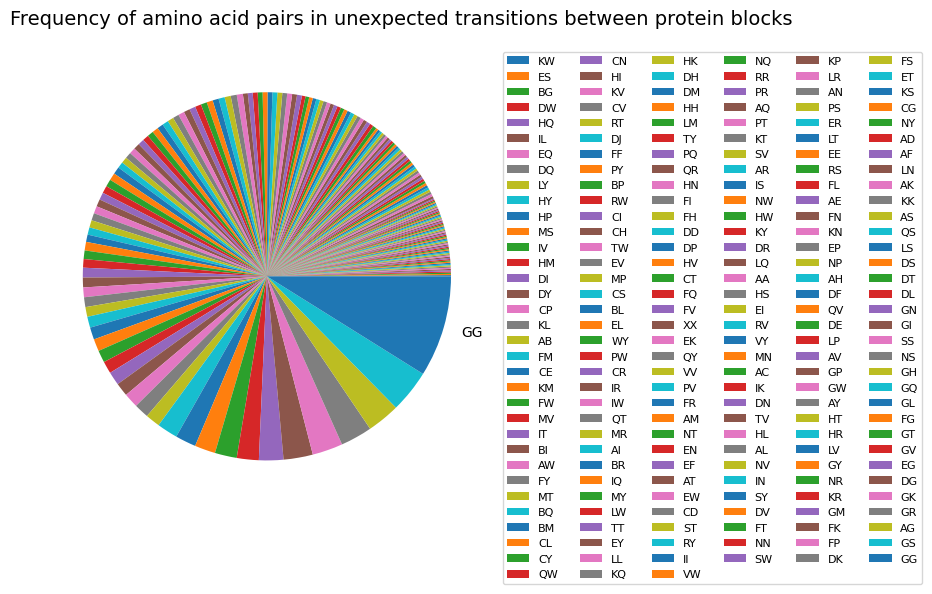

In [8]:
visualize_frequency(df_aa, 'amino acid')

#### The most frequent amino acid pair in unexpected transitions between protein blocks is GG.

## Determining secondary structures associated with unexpected transitions

In [9]:
df_s2, _ = filter_data_set(df, list(('Protein_number', 'PB1', 'PB2', 'expected_frequency', 'AA1', 'AA2')), 'S2_1-S2_2')
df_s2

,S2_1,S2_2,S2_1-S2_2,S2_1-S2_2-count
0,I,H,HI,1
1,I,I,II,1
2,B,H,BH,1
3,B,B,BB,1
4,I,S,IS,1
5,B,E,BE,1
6,S,E,ES,2
7,I,C,CI,2
8,G,E,EG,3
9,H,T,HT,5


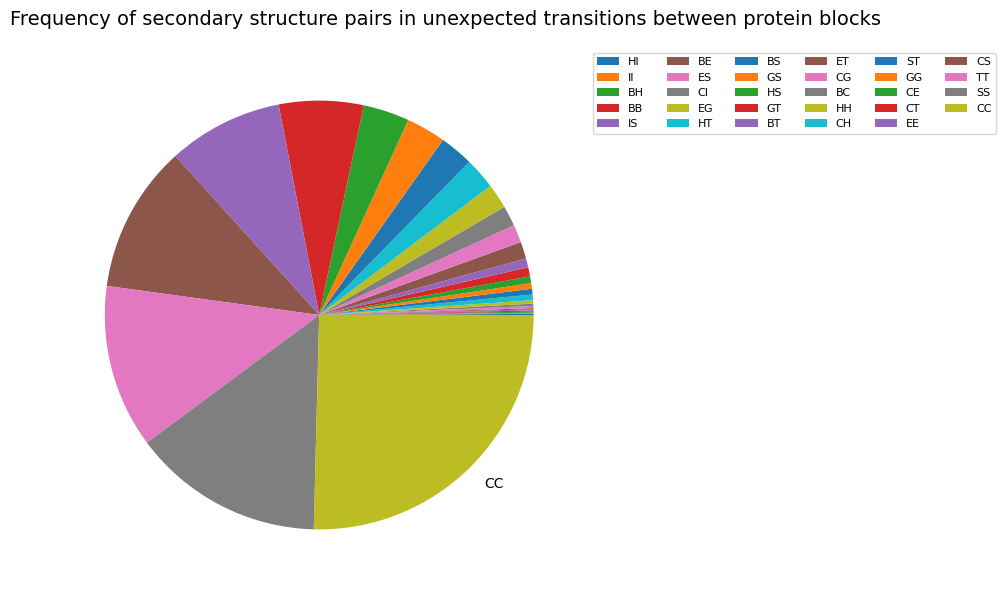

In [10]:
visualize_frequency(df_s2, 'secondary structure')

#### The most frequent secondary structure pair in unexpected transitions between protein blocks is CC.

## Determining which (AA1, AA2) & (S2_1, S2_2) combinations are in the transitions

In [11]:
df_aa_s2, _ = filter_data_set(df, list(('Protein_number', 'PB1', 'PB2', 'expected_frequency')), 'AA1-AA2-S2_1-S2_2')
df_aa_s2

,AA1,AA2,S2_1,S2_2,AA1-AA2-S2_1-S2_2,AA1-AA2-S2_1-S2_2-count
0,A,L,E,C,ACEL,1
1,E,N,S,C,CENS,1
2,N,G,C,C,CCGN,1
3,Y,G,T,T,GTTY,1
4,S,E,S,S,ESSS,1
...,...,...,...,...,...,...
772,G,a,T,T,AGTT,7
773,G,G,E,C,CEGG,8
774,G,G,T,T,GGTT,9
775,G,G,S,C,CGGS,9


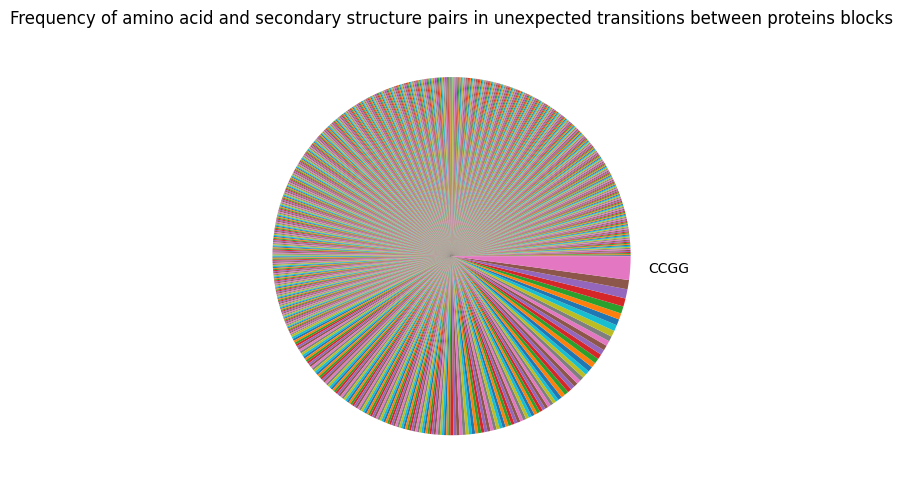

In [12]:
visualize_frequency(df_aa_s2, 'amino acid and secondary structure')

#### The most frequent (AA1, AA2) & (S2_1, S2_2) combination in unexpected transitions between protein blocks is GG CC.

## pLDDT value

In [13]:
Image(url="https://ftp.ebi.ac.uk/pub/training/2024/On-demand/pLDDT_fixed.gif")

#### pLDDT values range from 0 to 100 and pLDDT ≥ 90 indicates residues predicted with extremely high confidence, whereas residues with 90 > pLDDT ≥ 70 are classified as confident. 

In [14]:
df1 = pd.read_csv("March_2024_AF2_01.txt", sep=r"\s+", header=None)
df1.columns = ['Protein_number', 'res_number', 'PB1', 'PB2', 'AA1', 'AA2', 'S2_1', 'S2_2', 'expected_frequency', 'plDDT', 'RSA1', 'RSA2']
df1

,Protein_number,res_number,PB1,PB2,AA1,AA2,S2_1,S2_2,expected_frequency,plDDT,RSA1,RSA2
0,0,7,j,j,G,G,C,S,0.880055,60.180000,100.000000,100.000000
1,1,95,n,l,E,Q,T,T,0.736402,96.220001,89.762611,98.582039
2,1,219,i,d,G,N,S,C,0.040571,31.870001,100.000000,100.000000
3,1,222,d,i,T,V,C,C,0.021758,47.259998,100.000000,100.000000
4,1,223,i,d,V,P,C,C,0.040571,38.200001,100.000000,93.366096
...,...,...,...,...,...,...,...,...,...,...,...,...
671150,23508,14909273,j,d,G,L,C,C,0.623739,95.459999,1.531394,20.793951
671151,23508,14909291,f,d,C,D,P,S,0.047665,95.379997,11.473963,100.000000
671152,23508,14909390,j,d,G,P,S,P,0.623739,80.699997,65.849922,88.452087
671153,23508,14909434,g,f,L,T,C,C,0.430306,79.760002,60.491493,46.452702


In [15]:
# drop of common transitions between protein blocks
df1 = df1[df1[['PB1','PB2']].apply(tuple, axis=1).isin(df[['PB1','PB2']].apply(tuple, axis=1))].reset_index(drop=True)
df1

,Protein_number,res_number,PB1,PB2,AA1,AA2,S2_1,S2_2,expected_frequency,plDDT,RSA1,RSA2
0,0,7,j,j,G,G,C,S,0.880055,60.180000,100.000000,100.000000
1,1,219,i,d,G,N,S,C,0.040571,31.870001,100.000000,100.000000
2,1,222,d,i,T,V,C,C,0.021758,47.259998,100.000000,100.000000
3,1,223,i,d,V,P,C,C,0.040571,38.200001,100.000000,93.366096
4,4,472,f,d,D,T,C,C,0.047665,60.040001,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
538896,23508,14909167,f,f,P,A,C,S,0.151767,46.779999,49.140049,51.020409
538897,23508,14909168,f,l,A,W,S,C,0.017280,66.570000,51.020409,41.355038
538898,23508,14909170,k,m,A,C,H,H,0.026824,90.550003,5.668934,0.000000
538899,23508,14909190,p,k,G,M,C,T,0.265281,91.080002,44.410412,77.622803


### The pLDDT value in the general case for the entire dataset:

In [16]:
df1.describe()

,Protein_number,res_number,expected_frequency,plDDT,RSA1,RSA2
count,538901.000000,5.389010e+05,538901.000000,538901.000000,538901.000000,538901.000000
mean,12390.852606,7.558885e+06,0.393393,37.586782,92.459126,92.818022
std,6644.697647,4.333520e+06,0.258888,13.145442,18.013535,17.934032
min,0.000000,7.000000e+00,0.000000,5.920000,0.000000,0.000000
25%,7104.000000,3.939991e+06,0.179394,30.540001,93.450485,94.594597
50%,12627.000000,7.666910e+06,0.470296,34.570000,100.000000,100.000000
75%,17793.000000,1.118601e+07,0.618854,39.570000,100.000000,100.000000
max,23508.000000,1.490929e+07,0.900139,98.949997,100.000000,100.000000


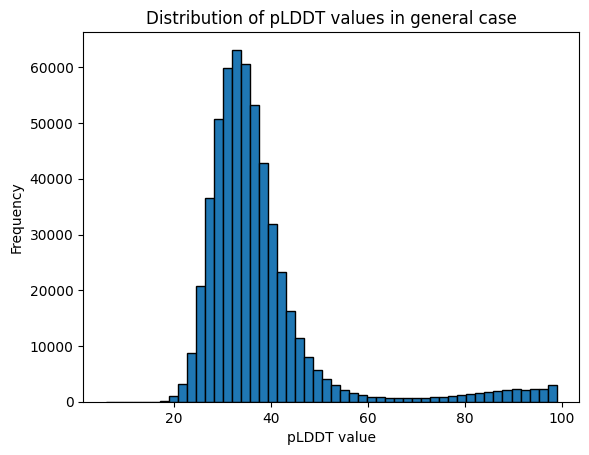

In [17]:
plt.hist(df1['plDDT'], bins=50, edgecolor='black')
plt.xlabel('pLDDT value')
plt.ylabel('Frequency')
plt.title('Distribution of pLDDT values in general case')
plt.show()

In [18]:
df1.describe()['plDDT']['mean'].item()

37.5867821919157

In [19]:
df1.describe()['plDDT']['75%'].item()

39.56999969

In [20]:
df1.describe()['plDDT']['max'].item()

98.94999695

#### Based on the mean value of 37.6, we can conclude that the pLDDT value is low when observed in the general case. Additionally, the 0.75 quantile value of 39.6 suggests the same, indicating that 75% of the pLDDT values in the dataset are below this value. But we can observe that the data also contains cases with extremely high pLDDT values – as high as 98.95. Additionally, if we look at the data distribution, it is clear that while high pLDDT values do occur, very low values are predominant.

### The pLDDT value in relation to protein blocks:

In [22]:
plddt_pb = df1.groupby(['PB1', 'PB2'], as_index=False)['plDDT'].mean()
plddt_pb

,PB1,PB2,plDDT
0,a,a,44.339518
1,a,i,38.255764
2,a,l,55.938937
3,a,n,80.694787
4,a,o,67.613355
...,...,...,...
101,p,i,52.431239
102,p,k,79.513161
103,p,n,88.728642
104,p,o,84.793949


In [23]:
plddt_pb[plddt_pb['plDDT'] >= 70]['plDDT'].count().item()

49

In [24]:
plddt_pb.describe()

,plDDT
count,106.000000
mean,63.454415
std,18.023050
min,33.597163
25%,45.888131
50%,65.646074
75%,79.848490
max,90.566951


#### According to the results, we determine that when observing the pLDDT values in relation to the protein blocks (in rare transitions), high values occur in 49 out of 106 protein block pairs - in 46% of them. Additionally, the average pLDDT value in relation to the protein blocks is 63.45, which suggests that in this case, the value tends to lean towards confident, i.e., high.